In [1]:
import xarray as xr
import pandas as pd
from utilities.plotting import *
from utilities.utils import *

In [2]:
gas_costs=[10, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 200, 250, 300, 500]#, 750, 1000] #, 2500, 7500, 10000]
countries = ['United States of America', 'Germany', 'China', 'Saudi Arabia']
colors = sns.color_palette("rocket", as_cmap=True)(np.linspace(0, 1, int(len(countries))*2)[2:])
case = 'CSP_storage'

In [3]:
vars_dict = {'cs_fraction': None, 'storage_ratio': None, 'system_cost': None}

for var in vars_dict.keys():
    variable_df = pd.DataFrame()
    for gas_cost in gas_costs:
        masked_dataset = mask_data_region(xr.open_dataset(f'output_data/{var}_{case}_gas{gas_cost}.nc'), get_world())
        variable_df = calculate_country_mean(variable_df, masked_dataset, var, countries, gas_cost)
    vars_dict[var] = variable_df

plotting_variables_df = pd.concat(
    [vars_dict[k] if i == 0 else vars_dict[k].drop(columns=['country', 'gas cost']) 
     for i, k in enumerate(vars_dict)], 
    axis=1
)

/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:160: RuntimeWarning: All-NaN slice encountered
  f'median {var}': [np.nanmedian(cs['value'].values) for cs in cs_frac_countries],
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:162: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(cs['value'].values) - np.nanpercentile(cs['value'], 10) for cs in cs_frac_countries
/home/awongel/miniconda3/envs/table_pypsa_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:165: RuntimeWarning: All-NaN slice encountered
  np.nanpercentile(cs['value'], 90) - np.nanmedian(cs['value'].values) for cs in cs_frac_countries
/central/groups/carnegie_poc/awongel/clab_concentrated_solar/utilities/utils.py:160: RuntimeWarning: All-NaN slice encountered
  f'median {var}': [np.nanmed

In [4]:
# print(plotting_variables_df)
# # Save the DataFrame to a CSV file
# plotting_variables_df.to_csv('output_data/plotting_variables_df.csv', index=False)

In [5]:
# for var in ['system_cost']: #['storage_ratio','system_cost','cs_fraction']:
#     for ic,country in enumerate(countries):
#         if not var == 'system_cost':
#             plot_line(plotting_variables_df, country, colors[ic], var)
#         else:
#             plot_cost_emissions_change(plotting_variables_df, country, colors[ic], var)

In [6]:
# for frac_threshold in ['0p0', '0p5']:
#     plot_result_map(f'output_data/gas_price_min_frac_CSP_storage_threshold{frac_threshold}.nc', 'CSP_storage', f'Concentrated solar thermal fraction >{float(frac_threshold.replace("p","."))*100}%', 'Gas fuel price ($/MWh)')

In [7]:
def calculate_mean_cost(filename, label, region="world"):
    """
    Calculate the mean cost of gas fuel from a given dataset file.
    """
    dataset = xr.open_dataset(filename)
    if region == "world":
        dataset = mask_data_region(dataset, get_world())
    else:
        dataset = mask_data_region(dataset, get_country(region))
    # Calculate the mean cost of gas fuel
    median_gas_cost = dataset['value'].mean().values
    print(f'Mean gas cost for {label}% case in {region}: ${median_gas_cost:.2f}/MWh')

calculate_mean_cost("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/gas_price_min_frac_CSP_storage_threshold0p5.nc", label="50")
calculate_mean_cost("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/gas_price_min_frac_CSP_storage_threshold0p0.nc", label="0")
print("\n")
for country in countries:
    calculate_mean_cost(f"/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/gas_price_min_frac_CSP_storage_threshold0p5.nc", label="50", region=country)


Mean gas cost for 50% case in world: $415.77/MWh
Mean gas cost for 0% case in world: $55.23/MWh


Mean gas cost for 50% case in United States of America: $69.12/MWh
Mean gas cost for 50% case in Germany: $250.00/MWh
Mean gas cost for 50% case in China: $72.19/MWh
Mean gas cost for 50% case in Saudi Arabia: $44.23/MWh


In [8]:
# Find mean system cost cell for each country
def find_median_cost_cell(filename, label, region="world"):
    """
    Find the median system cost cell for a given dataset file.
    """
    dataset = xr.open_dataset(filename)
    if region == "world":
        dataset = mask_data_region(dataset, get_world())
    else:
        dataset = mask_data_region(dataset, get_country(region))
    # Find the cell with the median system cost
    # Get the DataArray
    data_array = dataset['value']

    # Compute the median
    median_val = float(data_array.median())

    # Find the absolute difference
    diff = abs(data_array - median_val)

    # Identify the location (coords) of the closest value
    closest_point = diff.where(diff == diff.min(), drop=True)

    # Extract coordinate values directly
    x_val = closest_point['x'].values[0]
    y_val = closest_point['y'].values[0]

    print(f'Median system cost for {label}$/MWh case in {region}: ${median_val:.2f}/MWh at coordinates ({x_val:.2f}, {y_val:.2f})')

for country in countries:
    find_median_cost_cell("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/system_cost_CSP_storage_gas50.nc", label="50", region=country)
    find_median_cost_cell("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/system_cost_CSP_storage_gas10.nc", label="10", region=country)
    find_median_cost_cell("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/system_cost_CSP_storage_gas100.nc", label="100", region=country)
    find_median_cost_cell("/groups/carnegie_poc/awongel/clab_concentrated_solar/output_data/system_cost_CSP_storage_gas500.nc", label="500", region=country)

Median system cost for 50$/MWh case in United States of America: $467243.97/MWh at coordinates (-86.25, 33.25)
Median system cost for 10$/MWh case in United States of America: $173430.27/MWh at coordinates (-123.75, 25.75)
Median system cost for 100$/MWh case in United States of America: $622710.07/MWh at coordinates (-96.25, 30.75)
Median system cost for 500$/MWh case in United States of America: $1050583.58/MWh at coordinates (-113.75, 43.25)
Median system cost for 50$/MWh case in Germany: $542272.37/MWh at coordinates (6.25, 50.75)
Median system cost for 10$/MWh case in Germany: $173430.27/MWh at coordinates (6.25, 48.25)
Median system cost for 100$/MWh case in Germany: $883411.94/MWh at coordinates (6.25, 50.75)
Median system cost for 500$/MWh case in Germany: $2372337.14/MWh at coordinates (8.75, 50.75)
Median system cost for 50$/MWh case in China: $477409.42/MWh at coordinates (98.75, 25.75)
Median system cost for 10$/MWh case in China: $173430.27/MWh at coordinates (76.25, 23.25

In [9]:
# for gas_cost in [50, 500]:
#     plot_result_map(f'output_data/cs_fraction_CSP_storage_gas{gas_cost}.nc', 'CSP_storage', f'Gas fuel cost = ${gas_cost}/MWh', 'Fraction of demand met with concentrated solar')

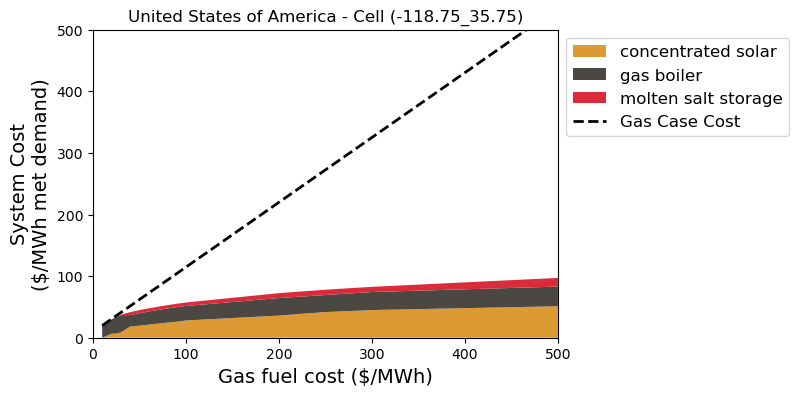

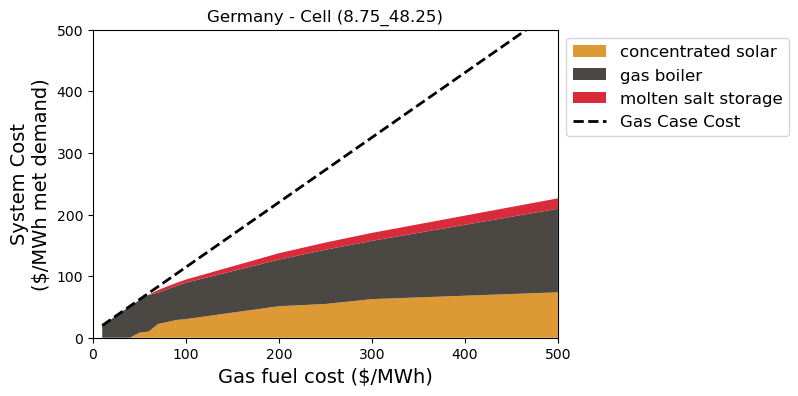

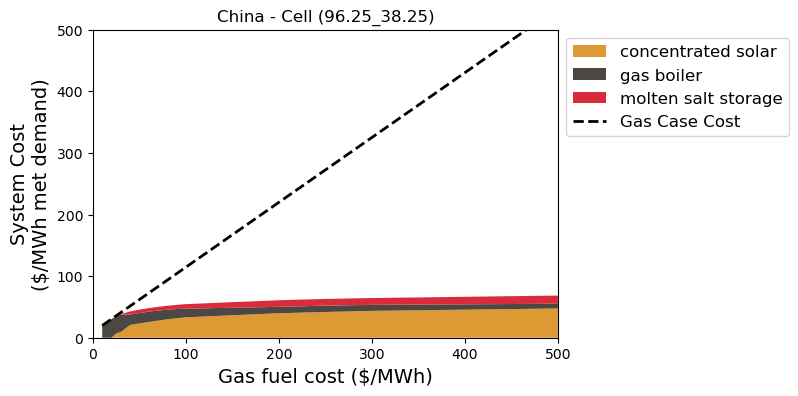

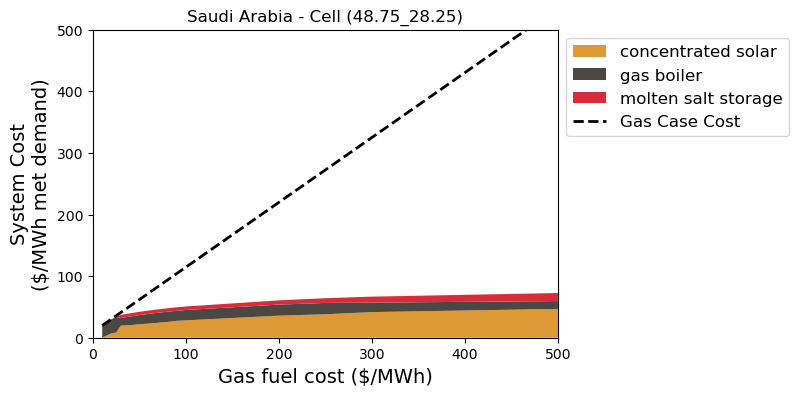

In [10]:
country_cell_dict = {
    'United States of America': ['-118.75°,35.75°', 70],
    'Germany': ['8.75°,48.25°', 250],
    'China': ['96.25°,38.25°', 70],
    'Saudi Arabia': ['48.75°,28.25°', 40]
}
for country in country_cell_dict.keys():
    # plot_dispatch_curve(country, country_cell_dict[country][0].replace("°","").replace(",","_"), country_cell_dict[country][1])
    plot_system_cost_share(country, country_cell_dict[country][0].replace("°","").replace(",","_"), gas_costs)